## Problem formulation and Data processing


In [27]:
import pandas as pd
jump_conditions = pd.DataFrame({'jump': range(1,10)
                                })

direction_conditions = pd.DataFrame({'direction':   ['north',   'south',    'east',     'west'  ],
                                     'delta_x_max': [2,         2,          3,          -2      ],
                                     'delta_y_max': [4,         -3,         2,          2       ],
                                     'delta_x_min': [-2,        -2,         2,          -3      ],
                                     'delta_y_min': [3,         -4,         -2,         -2      ]})

In [28]:
from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense

m = Container()
i = Set(m, name='i', description="The i'th jump", records=jump_conditions['jump'])
d = Set(m, name='d', description="jump direction", records=direction_conditions['direction'])
vert_d = Set(m, name='horz_d', description="horizontal directions", records=['north', 'south'])
horz_d = Set(m, name='vert_d', description="vertical directions", records=['east', 'west'])

#minmax_dy = Parameter(m, name='minmax_dy', description="(min, max) delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y']])
min_dx = Parameter(m, name='min_dx', description="min delta x for each direction", domain=d, records=direction_conditions[['direction','delta_x_min']])
max_dx = Parameter(m, name='max_dx', description="max delta x for each direction", domain=d, records=direction_conditions[['direction','delta_x_max']])
min_dy = Parameter(m, name='min_dy', description="min delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y_min']])
max_dy = Parameter(m, name='max_dy', description="max delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y_max']])

decisions = Variable(m, name='decisions', type='binary', description="jump decision in all direction at each time", domain=[i,d])

dx = Variable(m, name='dx', description="delta x for each jump", domain=[i,d])
dy = Variable(m, name='dy', description="delta y for each jump", domain=[i,d])

position_x = Variable(m, name='position_x', description="x position at each jump", domain=i)
position_y = Variable(m, name='position_y', description="y position at each jump", domain=i)

hax = Variable(m, name='hole_x', type='sos1', description="around the hole center in d direction", domain=[i, horz_d])
hay = Variable(m, name='hole_y', type='sos1', description="around the hole center in d direction", domain=[i, vert_d])

abs_dx = Variable(m, name='abs_dx', type='positive', description="absolute delta x for each jump", domain=[i])
abs_dy = Variable(m, name='abs_dy', type='positive', description="absolute delta y for each jump", domain=[i])

inhole = Variable(m, name='inhole', type='binary', description="is in the hole", domain=i)


## Equation 

In [29]:
# Bad box
(hole_miy, hole_may) = (7, 9)
(hole_mix, hole_max) = (6, 8)

# Get to end point.
(start_x, start_y) = (0, 0)
(end_x, end_y) = (13, 17)

# Absolute value of delta x and delta y
absdx_pos = Equation(m, name='absolute_delta_x_pos', description="Absolute value of delta x positive", domain=i)
absdx_pos[i] = abs_dx[i] >= Sum(d, dx[i,d])

absdx_neg = Equation(m, name='absolute_delta_x_neg', description="Absolute value of delta x negative", domain=i)
absdx_neg[i] = abs_dx[i] >= -Sum(d, dx[i,d])

absdy_pos = Equation(m, name='absolute_delta_y_pos', description="Absolute value of delta y positive", domain=i)
absdy_pos[i] = abs_dy[i] >= Sum(d, dy[i,d])

absdy_neg = Equation(m, name='absolute_delta_y_neg', description="Absolute value of delta y negative", domain=i)
absdy_neg[i] = abs_dy[i] >= -Sum(d, dy[i,d])

# Calculate current position
position_x.fx[i].where[i.first] = start_x
position_y.fx[i].where[i.first] = start_y
pox = Equation(m, name='position_eqx', description="Calculate current position x", domain=i)
pox[i].where[i.ord > 1] = position_x[i] == position_x[i-1] + Sum(d, dx[i-1,d])

poy = Equation(m, name='position_eqy', description="Calculate current position y", domain=i)
poy[i].where[i.ord > 1] = position_y[i] == position_y[i-1] + Sum(d, dy[i-1,d])

## Box constraints start

# Centralizing equations for further calculations
obx = Equation(m, name='outside_box_xaxis', description="Force to be outside box in xaxis", domain=i)
obx[i] = position_x[i] == (inhole[i])*(hole_mix+hole_max)/2 + hax[i,'west'] - hax[i,'east']

oby = Equation(m, name='outside_box_yaxis', description="Force to be outside box in yaxis", domain=i)
oby[i] = position_y[i] == (1-inhole[i])*(hole_miy+hole_may)/2 + hay[i,'north'] - hay[i,'south']


# SOS1 constraints - only one deviation can be non-zero for each axis while the other one must be larger than radius
r = 1e-4
haxlo = Equation(m, name='hole_axis_x_lower', description="Force to be outside box in x axis", domain=i)
haxlo[i] = Sum(horz_d, hax[i,horz_d]) >= (inhole[i])*((hole_max-hole_mix)/2 + r)

haylo = Equation(m, name='hole_axis_y_lower', description="Force to be outside box in y axis", domain=i)
haylo[i] = Sum(vert_d, hay[i,vert_d]) >= (1-inhole[i])*((hole_may-hole_miy)/2 + r)

## Box constraints end

# Force the delta to be in bound
midx = Equation(m, name='minimum_delta_x', description="Force the delta to be in bound", domain=[i,d])
midx[i,d] = dx[i,d] >= min_dx[d]*decisions[i,d]

madx = Equation(m, name='maximum_delta_x', description="Force the delta to be in bound", domain=[i,d])
madx[i,d] = dx[i,d] <= max_dx[d]*decisions[i,d]

midy = Equation(m, name='minimum_delta_y', description="Force the delta to be in bound", domain=[i,d])
midy[i,d] = dy[i,d] >= min_dy[d]*decisions[i,d]

mady = Equation(m, name='maximum_delta_y', description="Force the delta to be in bound", domain=[i,d])
mady[i,d]  = dy[i,d] <= max_dy[d]*decisions[i,d]      

# Jump in one direction at each time. (Forces to jump all i times if == 1)
cod = Equation(m, name='chose_one_direction', description="Jump in one direction at each time", domain=i)
cod[i] = Sum(d, decisions[i,d]) <= 1

# End condition
eax = Equation(m, name='end_at_x', description="forces to jump to end_x")
eax[...] = start_x + Sum((i,d), dx[i,d]) == end_x
eay = Equation(m, name='end_at_y', description="forces to jump to end_y")
eay[...] = start_y + Sum((i,d), dy[i,d]) == end_y

# Objective
#obj = Sum((i,d), decisions[i,d])
obj = Sum(i, abs_dx[i] + abs_dy[i])

In [30]:
jump = Model(m, name='jump', sense=Sense.MIN, objective=obj, equations=m.getEquations(), problem="MIP")
jump.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,30,244,190,MIP,CPLEX,0.039


## Primals


In [31]:
dyf = pd.DataFrame(dy.l.records).pivot(index='i', columns='d', values='level')
dxf = pd.DataFrame(dx.l.records).pivot(index='i', columns='d', values='level')
dec_f = pd.DataFrame(decisions.l.records).pivot(index='i', columns='d', values='level')

dyf = dyf.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)
dxf = dxf.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)
dec_f = dec_f.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)

In [32]:
import numpy as np

x_path = np.insert(dxf.sum(axis=1).cumsum().to_numpy(), 0, start_x)
y_path = np.insert(dyf.sum(axis=1).cumsum().to_numpy(), 0, start_y)

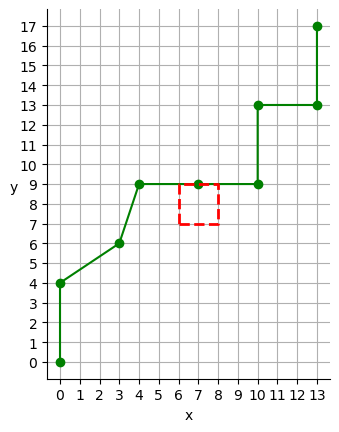

In [33]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
ax.plot(x_path, y_path, 'go-')
ax.plot([hole_mix, hole_max, hole_max, hole_max, hole_max, hole_mix, hole_mix, hole_mix],
         [hole_miy, hole_miy, hole_may, hole_may, hole_may, hole_may, hole_miy, hole_miy],
         'r--', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.spines[['right', 'top']].set_visible(False)
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(range(14))
ax.set_yticks(range(18))

In [34]:
position_x.l.records, position_y.l.records

(   i  level
 0  1    0.0
 1  2    0.0
 2  3    3.0
 3  4    4.0
 4  5    7.0
 5  6   10.0
 6  7   10.0
 7  8   13.0
 8  9   13.0,
    i    level
 0  1   0.0000
 1  2   4.0000
 2  3   6.0000
 3  4   9.0001
 4  5   9.0001
 5  6   9.0001
 6  7  13.0001
 7  8  13.0001
 8  9  13.0001)